In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append("..")

import jax
import jax.numpy as jnp
from jax import vmap, jit
import haiku as hk

In [2]:
from evosax.problems.bernoulli_bandit import reset, step, env_params
from evosax.strategies.cma_es import init_strategy, ask, tell, check_termination
from evosax.utils import (init_logger, update_logger, flat_to_network,
                          get_total_params, get_network_shapes)

# Haiku Meta-RNN

In [3]:
def lstm_episode_rollout(env_params):
    """ Rollout a bandit episode with RNN policy. """
    core = hk.LSTM(32)
    dense = hk.Linear(2)
    lstm_state = core.initial_state(1)
    rng = hk.next_rng_key()
    rng, rng_reset = jax.random.split(rng)
    
    # Reset bandit env + placeholder network fct. (use candidate params)
    obs, state = reset(rng_reset, env_params)
    
    cum_reward = 0
    # Loop over episode timesteps and LSTM policy steps
    for t in range(env_params["max_steps"]):
        # Generate rng keys for action sampling and step transition
        rng, rng_action, rng_step = jax.random.split(rng, 3)
        # Perform forward through RNN and sample action
        x, lstm_state = core(jnp.expand_dims(obs, 0), lstm_state)
        logits = dense(x)
        action = hk.multinomial(rng_action, logits, 1).squeeze()
        # Perform step transition
        obs, state, reward, done, _ = step(rng_step, env_params,
                                           state, action)
        cum_reward += reward
    return cum_reward

In [4]:
rng = jax.random.PRNGKey(0)
rng, rng_net = jax.random.split(rng)
rollout_episode = hk.transform(lstm_episode_rollout)
net_params = rollout_episode.init(rng_net, env_params)
#rollout_episode_jit = jit(rollout_episode.apply, static_argnums=2)
#rollout_episode_jit(net_params, rng, env_params)
rollout_episode.apply(net_params, rng, env_params)

DeviceArray(56, dtype=int32)

# Bandit-LSTM CMA-ES optimization

In [5]:
total_no_params = get_total_params(net_params)
network_shapes = get_network_shapes(net_params)
print(total_no_params, network_shapes)

4802 FrozenDict({
    lstm/linear: {
        w: (36, 128),
        b: (128,),
    },
    linear: {
        w: (32, 2),
        b: (2,),
    },
})


In [6]:
batch_rollout = jit(vmap(rollout_episode.apply, in_axes=(None, 0, None), out_axes=0), static_argnums=(2,))
batch_keys = jax.random.split(rng, 2)
#ep_rewards = batch_rollout(net_params, batch_keys, env_params)
#ep_rewards

In [7]:
def reshape_and_eval(rng, x, network_shapes, env_params):
    """ Perform both parameter reshaping and evaluation in one go. """
    net_params = flat_to_network(x, network_shapes)
    returns = batch_rollout(net_params, rng, env_params)
    return - returns.mean()

#x = jnp.zeros(total_no_params)
#reshape_and_eval(batch_keys, x, network_shapes, env_params)

In [8]:
generation_fitness = vmap(reshape_and_eval, in_axes=(None, 0, None, None))
#xs = jnp.stack([x, x])
#generation_fitness(batch_keys, xs, network_shapes, env_params)

In [9]:
num_generations = 50
pop_size = 10
elite_size = 5
mean_init = jnp.zeros((total_no_params, ))
sigma_init = 1

top_k = 5
evo_logger = init_logger(top_k, total_no_params)
params, memory = init_strategy(mean_init, sigma_init,
                               pop_size, elite_size)
fit = []
for g in range(num_generations):
    # Explicitly handle random number generation
    rng, rng_ask, rng_eval = jax.random.split(rng, 3)
    batch_keys = jax.random.split(rng_eval, 10)
    # Ask for the next generation population to test
    x, memory = ask(rng_ask, params, memory)
    # Evaluate the fitness of the generation members
    fitness = generation_fitness(batch_keys, x,
                                 network_shapes, env_params)
    
    # x, fitness = rank_shaped_fitness(x, fitness)
    # Tell/Update the CMA-ES with newest data points
    memory = tell(x, fitness, params, memory)
    evo_logger = update_logger(evo_logger, x, fitness, memory, top_k,
                               verbose=True)
    

[DeviceArray(1, dtype=int32)] [-66.5 -65.9 -65.2 -55.8 -52.7]
[DeviceArray(1, dtype=int32), DeviceArray(2, dtype=int32)] [-66.5 -65.9 -65.3 -65.2 -64.2]
[DeviceArray(1, dtype=int32), DeviceArray(2, dtype=int32), DeviceArray(3, dtype=int32)] [-66.5 -65.9 -65.3 -65.2 -64.2]
[DeviceArray(1, dtype=int32), DeviceArray(2, dtype=int32), DeviceArray(3, dtype=int32), DeviceArray(4, dtype=int32)] [-66.5 -65.9 -65.3 -65.2 -64.2]
[DeviceArray(1, dtype=int32), DeviceArray(2, dtype=int32), DeviceArray(3, dtype=int32), DeviceArray(4, dtype=int32), DeviceArray(5, dtype=int32)] [-66.5 -65.9 -65.3 -65.2 -64.2]
[DeviceArray(1, dtype=int32), DeviceArray(2, dtype=int32), DeviceArray(3, dtype=int32), DeviceArray(4, dtype=int32), DeviceArray(5, dtype=int32), DeviceArray(6, dtype=int32)] [-66.5 -65.9 -65.3 -65.2 -64.2]
[DeviceArray(1, dtype=int32), DeviceArray(2, dtype=int32), DeviceArray(3, dtype=int32), DeviceArray(4, dtype=int32), DeviceArray(5, dtype=int32), DeviceArray(6, dtype=int32), DeviceArray(7, dty

# Visualize Evo Run Results

In [11]:
from evosax.visualize.plot_log import plot_fitness, plot_sigma
import matplotlib.pyplot as plt

(<Figure size 864x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fab30e5be10>)

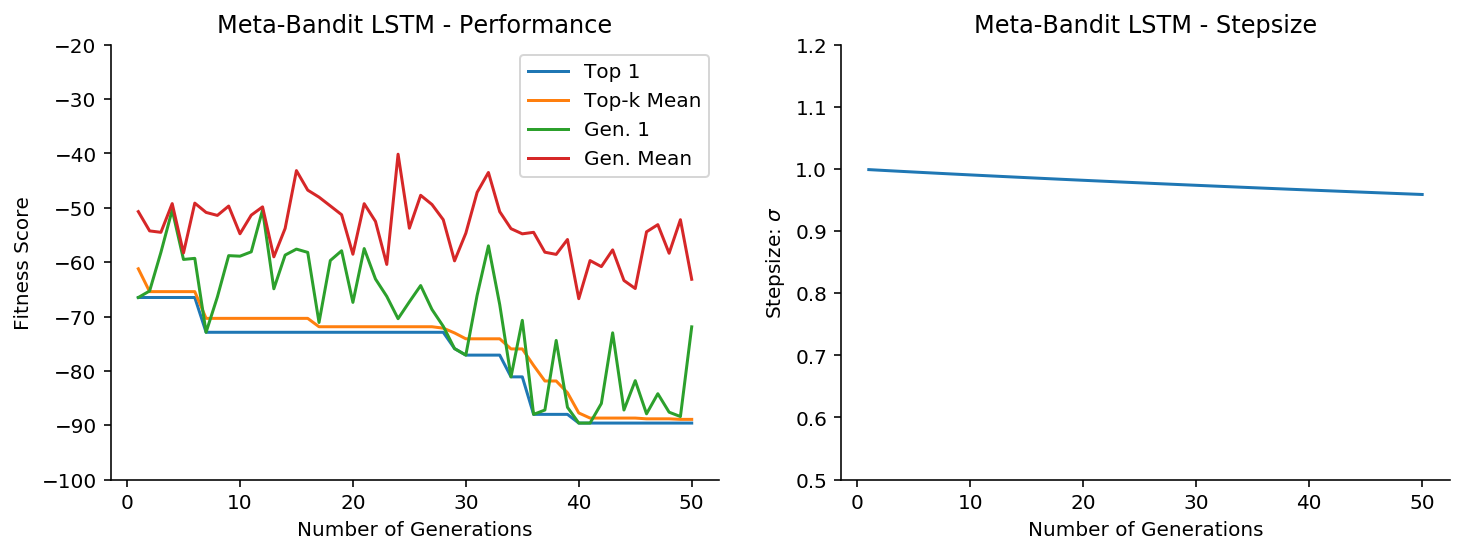

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_fitness(evo_logger, title="Meta-Bandit LSTM - Performance", ylims=(-100, -20), fig=fig, ax=axs[0])
plot_sigma(evo_logger, title="Meta-Bandit LSTM - Stepsize", ylims=(0.5, 1.2), fig=fig, ax=axs[1])